In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statistics import mean
from functools import reduce
import math

In [3]:
file = pd.ExcelFile("data.xlsx")

In [4]:
R_Cu = file.parse(sheet_name = 'Лист1', header=0, usecols='A').values.flatten() # Ом*10^(-1)
R_пп = file.parse(sheet_name = 'Лист1', header=0, usecols='B').values.flatten() # Ом*10^(-1)
U = file.parse(sheet_name = 'Лист1', header=0, usecols='C').values.flatten() #мВ
U_error = 10 #мкВ
R_error = 0.1 #Ом
R_Cu = [R_Cu[i]*10 for i in range(len(U))] #чтобы были Омы
R_пп = [R_пп[i]*10 for i in range(len(U))] #чтобы были Омы

In [5]:
#строим график термопары медь-константан (вообще константа термопары 41*10^6 В/градус)
T_table = [0,10,20,30,40,50,60,70,80,90,100,110]
U_table = [0,400,780,1190,1610,2030,2470,2910,3360,3810,4280,4740]
U_table_error = [1,20,20,20,20,20,20,20,20,20,20,20]

[0.02314571 1.8034383 ]


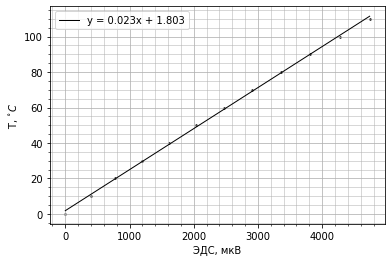

In [6]:
fig, ax = plt.subplots()
plt.scatter(U_table, T_table, color = 'black', s = 2)
#plt.errorbar(U_table, T_table, xerr = U_table_error,fmt='none',ecolor = 'black',elinewidth = 1)

z = np.polyfit(U_table, T_table, 1)
f = np.poly1d(z)
f_new = np.linspace(U_table[0],U_table[-1], 100)
l_new = f(f_new)

print(f.c) # вывели коэффициенты a и b соответственно (y = ax+b)

plt.plot(f_new, l_new, linewidth = 1, color = 'black', label = 'y = 0.023x + 1.803')

plt.grid(True)
ax.minorticks_on()
ax.grid(which='major', linewidth = 0.75)
ax.grid(which='minor', linewidth = 0.5)
ax.set_ylabel('Т, $^{\circ}C$')
ax.set_xlabel('ЭДС, мкВ')
plt.legend()
plt.show()
fig.savefig('graph.png', dpi = 1000)

In [7]:
#погрешность по МНК
def Dii(a):
    d = 0
    avg = reduce(lambda x, y: x + y, a) /len(a)
    for i in range(len(a)):
        d += (a[i] - avg)**2
    return d/len(a)

def sigma_b(x, sigmak):
    b = 0
    for i in range(len(x)):
        b += x[i]**2
    return sigmak*np.sqrt(b/len(x))

def sigma_k(x, y, k):
    return np.sqrt(abs(Dii(y)/Dii(x) - (k)**2)/(len(x)-2))


s_k = sigma_k(U_table, T_table, f.c[0])
s_b = sigma_b(U_table, s_k)

print('k =', f.c[0], 'sigma_k =', s_k)
print('b =', f.c[1], 'sigma_b =', s_b)

k = 0.023145712125283567 sigma_k = 0.00021345646805219387
b = 1.8034382987233135 sigma_b = 0.5847635948988985


In [8]:
T = [0]*len(U)
T_error = [0]*len(U)
for i in range (len(U)):
    T[i] = U[i]*1000*f.c[0] + f.c[1] + 23+273 # +23 - комнатная температура, +273 - перевели в Кельвины
    #T[i] = (U[i]*1000)/41 + 23 
    
#погрешность при использовании графика термопары медь-константан:
T_error = [np.sqrt((U[i]*s_k)**2 + (f.c[0]*U_error)**2 + s_b*2) for i in range (len(T_error))]

[-0.04265993 28.00729582]


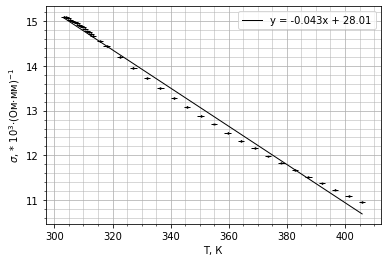

In [9]:
fig, ax = plt.subplots()

sigma_Cu = [0]*len(R_Cu)
for i in range (len(R_Cu)):
    sigma_Cu[i] = 13400/(R_Cu[i]*0.07**2)/1000 #делила на 1000 для подгона, картинка не влезала
    
# погрешность электропроводности:
sigma_Cu_error = [0]*len(sigma_Cu)
sigma_Cu_error = [13400/(R_Cu[i]**2*0.07**2)/1000*R_error for i in range (len(sigma_Cu_error))] #делила на 1000 для подгона, картинка не влезала


plt.scatter(T, sigma_Cu, color = 'black', s = 2)

z = np.polyfit(T, sigma_Cu, 1)
f1 = np.poly1d(z)
f1_new = np.linspace(T[0],T[-1], 100)
l1_new = f1(f1_new)

print(f1.c) # вывели коэффициенты a и b соответственно (y = ax+b) нужно умножить на 1000, если оставили коэффициент 1000 в sigma_Cu

plt.plot(f1_new, l1_new, linewidth = 1, color = 'black', label = 'y = -0.043x + 28.01')
plt.errorbar(T, sigma_Cu,yerr = sigma_Cu_error, xerr = T_error,fmt='none',ecolor = 'black',elinewidth = 1)
plt.grid(True)
ax.minorticks_on()
ax.grid(which='major', linewidth = 0.75)
ax.grid(which='minor', linewidth = 0.5)
ax.set_ylabel('$\sigma$, * 10$^3$$\cdot$(Ом$\cdot$мм)$^{-1}$')
ax.set_xlabel('Т, К')
plt.legend()
plt.show()
fig.savefig('sigma_Cu(T).png', dpi = 1000)

In [10]:
alpha = [0]*len(sigma_Cu)
alpha_error = [0]*len(alpha)
for i in range (len(sigma_Cu)):
    alpha[i] = -f1.c[0]/sigma_Cu[i]
    alpha_error[i] = np.sqrt((f1.c[0]*sigma_Cu_error[i]/sigma_Cu[i]**2)**2 + (1/sigma_Cu[i])**2)
print("Среднее значение коэффициента теплопроводности:", mean(alpha), "+-", max(alpha_error)/1000) # разделила на 1000, т.к. подгоняла в sigma_Cu

Среднее значение коэффициента теплопроводности: 0.003179356721324604 +- 9.127164180437562e-05


[ 2.36433545e-07 -2.50692514e-04  1.05147993e-01 -2.09488458e+01
  1.68299924e+03]


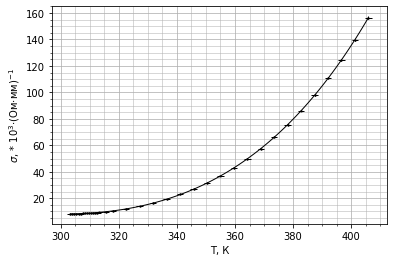

In [11]:
fig, ax = plt.subplots()

sigma_пп = [0]*len(R_пп)
for i in range (len(R_пп)):
    sigma_пп[i] = 39.2/(R_пп[i]*4.1**2)*10**3
    
    
# погрешность электропроводности:
sigma_пп_error = [0]*len(sigma_пп)
sigma_пп_error = [39.2/(R_пп[i]**2*4.1**2)*10**3*R_error for i in range (len(sigma_пп_error))]


plt.scatter(T, sigma_пп, color = 'black', s = 2)

z = np.polyfit(T, sigma_пп, 4)
f2 = np.poly1d(z)
f2_new = np.linspace(T[0],T[-1], 100)
l2_new = f2(f2_new)

print(f2.c) # вывели коэффициенты a,b,c,d,e соответственно (y = ax^4+bx^3+cx^2+dx+e) нужно умножить на 1000, если оставили коэффициент 1000 в sigma_пп

plt.plot(f2_new, l2_new, linewidth = 1, color = 'black')
plt.errorbar(T, sigma_пп,yerr = sigma_пп_error, xerr = T_error,fmt='none',ecolor = 'black',elinewidth = 1)
plt.grid(True)
ax.minorticks_on()
ax.grid(which='major', linewidth = 0.75)
ax.grid(which='minor', linewidth = 0.5)
ax.set_ylabel('$\sigma$, * 10$^3$$\cdot$(Ом$\cdot$мм)$^{-1}$')
ax.set_xlabel('Т, К')
plt.show()
fig.savefig('sigma_пп(T).png', dpi=1000)

[-4.11039612 15.18833495]


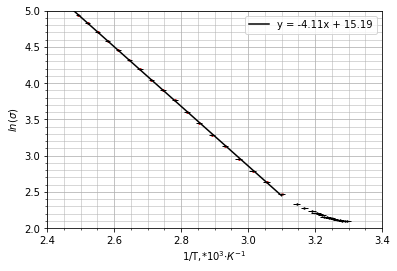

In [12]:
fig, ax = plt.subplots()
ln_пп = [math.log(sigma_пп[i]) for i in range (len(sigma_пп))]
ln_пп_error = [sigma_пп_error[i]/sigma_пп[i] for i in range (len(ln_пп))]
T_обр = [1/T[i]*1000 for i in range (len(T))]
T_обр_error = [T_error[i]*1000/T[i]**2 for i in range (len(T_обр))]

z = np.polyfit(T_обр[17:], ln_пп[17:], 1)
f3 = np.poly1d(z)
plt.plot(T_обр[17:], f3(T_обр[17:]), color = 'black', label = 'y = -4.11x + 15.19')

print(f3.c) # вывели коэффициенты a и b соответственно (y = ax+b)


plt.errorbar(T_обр, ln_пп,yerr = ln_пп_error, xerr = T_обр_error,fmt='none',ecolor = 'black',elinewidth = 1)
plt.scatter(T_обр, ln_пп, color = 'black', s = 2)
plt.scatter(T_обр[17:], ln_пп[17:], s = 2, c = 'red') # по красным точкам строим аппроксимацию
plt.grid(True)
ax.minorticks_on()
ax.grid(which='major', linewidth = 0.75)
ax.grid(which='minor', linewidth = 0.5)
plt.axis([2.4, 3.4, 2, 5])
ax.set_ylabel('$ln(\sigma)$')
ax.set_xlabel('1/Т,*10$^3$$\cdot$$К^{-1}$')
plt.legend()
plt.show()
fig.savefig('ln(sigma_пп).png', dpi=1000)

[-1.96398335  7.25711979]


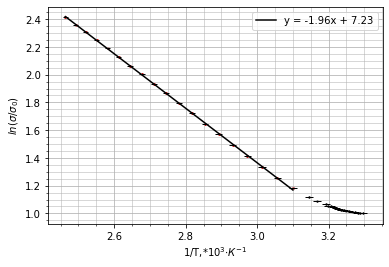

In [13]:
fig, ax = plt.subplots()
ln_sigma_sigma_0 = [ln_пп[i]/ln_пп[0] for i in range (len(ln_пп))]
ln_sigma_sigma_0_error = [np.sqrt((ln_пп_error[0]/ln_пп[i])**2 + (ln_пп_error[0]/(ln_пп[i]*ln_пп[0]))**2) for i in range (len(ln_sigma_sigma_0))]

z = np.polyfit(T_обр[17:], ln_sigma_sigma_0[17:], 1)
f4 = np.poly1d(z)
plt.plot(T_обр[17:], f4(T_обр[17:]), color = 'black', label = 'y = -1.96x + 7.23')

print(f4.c) # вывели коэффициенты a и b соответственно (y = ax+b)


plt.errorbar(T_обр, ln_sigma_sigma_0,yerr = ln_sigma_sigma_0_error, xerr = T_обр_error,fmt='none',ecolor = 'black',elinewidth = 1)
plt.scatter(T_обр, ln_sigma_sigma_0, color = 'black', s = 2)
plt.scatter(T_обр[17:], ln_sigma_sigma_0[17:], s = 2, c = 'red') # по красным точкам строим аппроксимацию
plt.grid(True)
ax.minorticks_on()
ax.grid(which='major', linewidth = 0.75)
ax.grid(which='minor', linewidth = 0.5)
ax.set_ylabel('$ln(\sigma / \sigma_{0})$')
ax.set_xlabel('1/Т,*10$^3$$\cdot$$К^{-1}$')
plt.legend()
plt.show()
fig.savefig('ln(sigma_0).png', dpi=1000)

In [14]:
# в моем случае второй график, который нормированный на первое значение электропроводимости, хуже ложится на теорию, поэтому 
# использую ненормированный график

delta = -f3.c[0]*1000*2*1.38*10**(-23)*6.24*10**18 # коэффициент наклона умножила на 1000, тк делила на 1000 в Т_обр
a_error = sigma_k(T_обр, ln_пп, f3.c[0])
delta_error = a_error*1000*2*1.38*10**(-23)*6.24*10**18
print ('Ширина запрещенной зоны:(', delta, '+-',delta_error,') эВ')

#для нормированного графика
#delta = -f4.c[0]*1000*2*1.38*10**(-23)*6.24*10**18 # коэффициент наклона умножила на 1000, тк делила на 1000 в Т_обр
#a_error = sigma_k(T_обр, ln_sigma_sigma_0, f4.c[0])
#delta_error = a_error*1000*2*1.38*10**(-23)*6.24*10**18
#print ('Ширина запрещенной зоны:(', delta, '+-',delta_error,') эВ')

Ширина запрещенной зоны:( 0.7079088606196446 +- 0.05382413003488026 ) эВ


In [15]:
#Выгрузить данные в эксель

from pandas import DataFrame
df = DataFrame({'R_Cu': R_Cu, 'R_пп': R_пп,'T': T, 'T_error': T_error, 'sigma_Cu': sigma_Cu, 'sigma_Cu_error': sigma_Cu_error,
               'sigma_пп': sigma_пп, 'sigma_пп_error': sigma_пп_error, 'ln_пп': ln_пп, 'ln_пп_error': ln_пп_error, 'T_обр': T_обр,
                'T_обр_error': T_обр_error, 'ln_sigma_sigma_0': ln_sigma_sigma_0, 'ln_sigma_sigma_0_error': ln_sigma_sigma_0_error})
df.to_excel('scint.xlsx', sheet_name='Лист1', index=False)